# Inventory Demand Forecasting and Warehouse Optimization

## **Project Overview**
This project focuses on improving warehouse efficiency and customer insights using predictive analytics and data engineering. The primary goals include:

1. **ETL Pipeline Development**: Automating data extraction, transformation, and loading to handle large datasets efficiently.
2. **Demand Forecasting**: Using time-series analysis to predict inventory needs and reduce stockouts or overstocking.
3. **Warehouse Optimization**: Grouping products based on demand patterns to optimize layouts, reduce storage costs, and improve retrieval efficiency.
4. **Customer Segmentation**: Identifying customer purchasing behavior using RFM analysis for better targeting and personalized services.
5. **Visualization**: Building dashboards for monitoring trends and enabling proactive inventory and customer management.

---

## **Steps in the Project**

### **1. Data Cleaning**
- Handle missing values and invalid data (e.g., negative or zero quantities and prices).
- Convert date columns to a proper datetime format.
- Add derived fields like `TotalPrice` to calculate the transaction value.

### **2. Exploratory Data Analysis (EDA)**
- Analyze transaction patterns by countries, products, and time.
- Visualize trends like monthly sales or top-performing countries.

### **3. Demand Forecasting**
- Predict future inventory demand using time-series modeling (Holt-Winters exponential smoothing).
- Visualize the forecast to ensure alignment with business expectations.

### **4. Warehouse Optimization**
- Cluster products based on demand patterns using K-means clustering.
- Visualize clusters to identify groups of similar products for layout optimization.

### **5. Customer Segmentation**
- Perform RFM (Recency, Frequency, Monetary) analysis.
- Segment customers based on their RFM scores into categories like "Loyal Customers" and "At Risk."
- Visualize the segmentation for better business insights.

### **6. Visualization Dashboard**
- Export data for dashboards (e.g., Tableau/Power BI) or visualize within the notebook.
- Create clear and actionable visualizations for stakeholders.

---

## **Technologies Used**
- **Python Libraries**: Pandas, NumPy, Matplotlib, Seaborn, Scikit-learn, Statsmodels.
- **ETL Tools**: PySpark and SQL.
- **Visualization**: Tableau/Power BI, Matplotlib, Seaborn.
- **Machine Learning**: K-means clustering, Holt-Winters time series forecasting.

---

## **Instructions to Execute**
- Load the dataset into a Python environment (e.g., Google Colab or Jupyter Notebook).
- Follow the step-by-step code provided for data cleaning, EDA, modeling, and segmentation.
- Export the processed data for visualization or use the built-in plots for insights.




# 1. DATA CLEANING

In [2]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


In [7]:
file_path = '/content/drive/MyDrive/Colab Notebooks/InventoryProject/Dataset.csv'
df = pd.read_csv(file_path)
print(df.head(5))

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

        InvoiceDate  UnitPrice  CustomerID         Country  
0  01-12-2010 08:26       2.55     17850.0  United Kingdom  
1  01-12-2010 08:26       3.39     17850.0  United Kingdom  
2  01-12-2010 08:26       2.75     17850.0  United Kingdom  
3  01-12-2010 08:26       3.39     17850.0  United Kingdom  
4  01-12-2010 08:26       3.39     17850.0  United Kingdom  


In [8]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [10]:
df = df.dropna(subset=['CustomerID'])

In [11]:
try:
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format="%d-%m-%Y %H:%M")
except ValueError as e:
    print("Error converting InvoiceDate:", e)
    print(df[~df['InvoiceDate'].str.match(r'\d{2}-\d{2}-\d{4} \d{2}:\d{2}')])

df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

<ipython-input-11-fe74f7e5d3fa>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format="%d-%m-%Y %H:%M")
<ipython-input-11-fe74f7e5d3fa>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TotalPrice'] = df['Quantity'] * df['UnitPrice']


In [12]:
len(df)

406829

# 2. Exploratory Data Analysis (EDA)

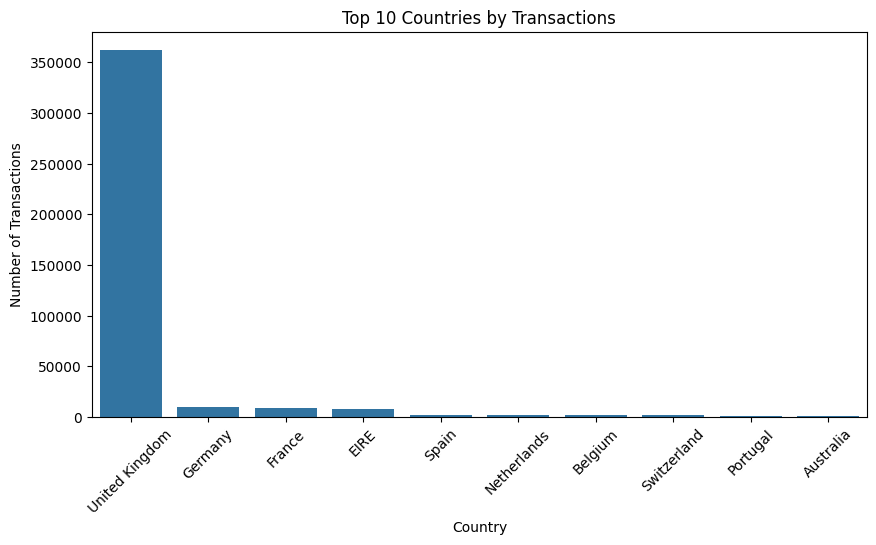

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Top 10 countries by number of transactions
top_countries = df['Country'].value_counts().head(10)
plt.figure(figsize=(10, 5))
sns.barplot(x=top_countries.index, y=top_countries.values)
plt.title("Top 10 Countries by Transactions")
plt.ylabel("Number of Transactions")
plt.xticks(rotation=45)
plt.show()


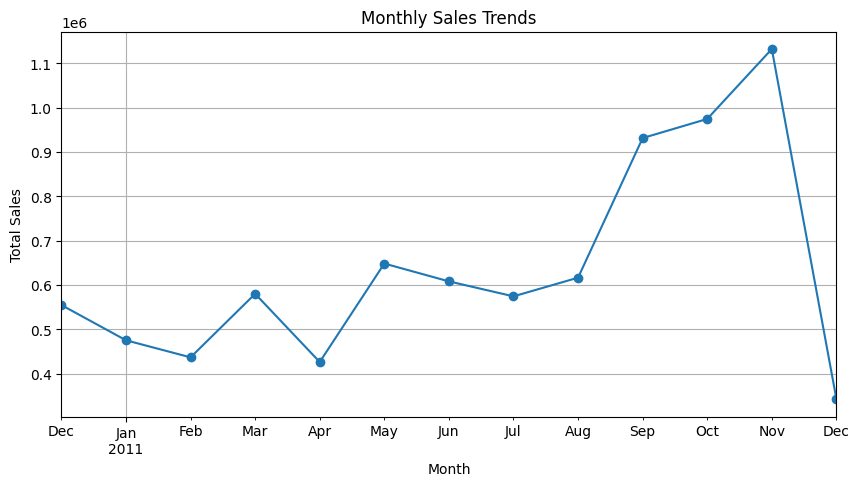

In [14]:
# Monthly sales trends
df['Month'] = df['InvoiceDate'].dt.to_period('M')
monthly_sales = df.groupby('Month')['TotalPrice'].sum()

plt.figure(figsize=(10, 5))
monthly_sales.plot(kind='line', marker='o')
plt.title("Monthly Sales Trends")
plt.ylabel("Total Sales")
plt.xlabel("Month")
plt.grid()
plt.show()

# Demand Forecasting

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


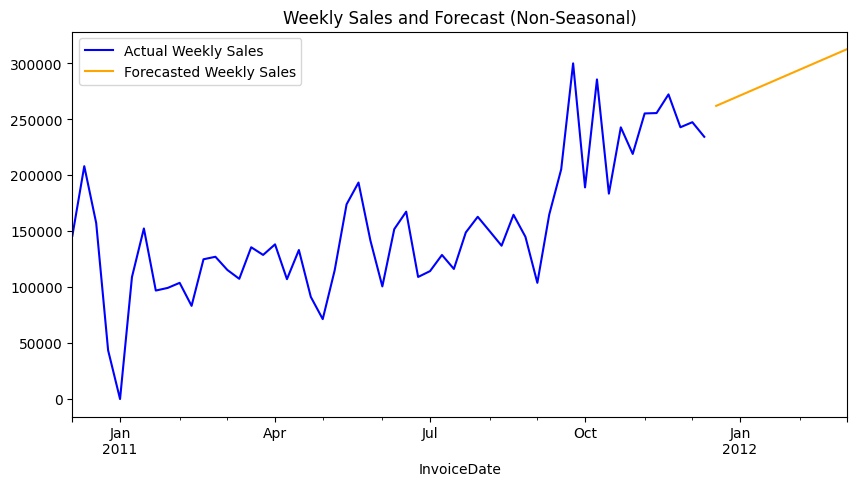

In [18]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Aggregate data to weekly sales
weekly_sales = df.resample('W', on='InvoiceDate')['TotalPrice'].sum()

# Fit a non-seasonal model (trend only)
model = ExponentialSmoothing(weekly_sales, trend="add", seasonal=None)  # No seasonal component
fitted_model = model.fit()

# Forecast for the next 12 weeks
forecast = fitted_model.forecast(12)

# Plot the original data and the forecast
plt.figure(figsize=(10, 5))
weekly_sales.plot(label="Actual Weekly Sales", color='blue')
forecast.plot(label="Forecasted Weekly Sales", color='orange')
plt.title("Weekly Sales and Forecast (Non-Seasonal)")
plt.legend()
plt.show()


#Observations:
Trend Continuation: The forecast assumes a steady upward trend, which is typical for non-seasonal models with a trend component.
Smooth Forecast: Since we removed seasonality, the forecast is a smoothed continuation of the trend.

## Warehouse optimization

In [21]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Aggregate product demand
product_demand = df.groupby('StockCode')['Quantity'].sum().reset_index()

# Normalize the data
scaler = StandardScaler()
product_demand['Quantity_scaled'] = scaler.fit_transform(product_demand[['Quantity']])

# Apply k-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
product_demand['Cluster'] = kmeans.fit_predict(product_demand[['Quantity_scaled']])



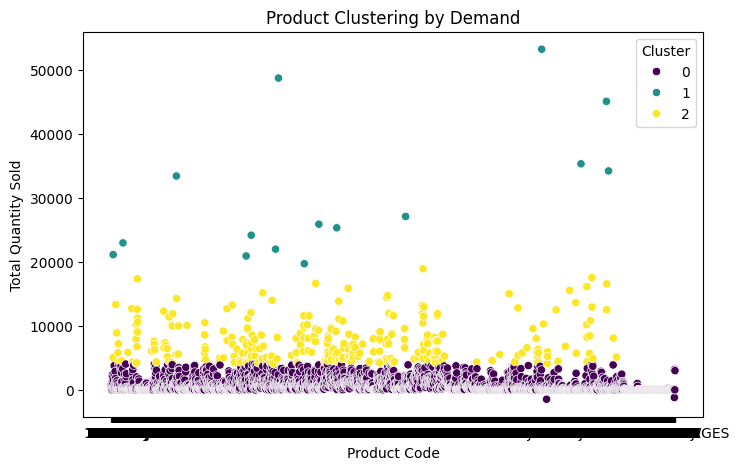

In [20]:
# Visualize clusters
plt.figure(figsize=(8, 5))
sns.scatterplot(data=product_demand, x='StockCode', y='Quantity', hue='Cluster', palette='viridis')
plt.title("Product Clustering by Demand")
plt.xlabel("Product Code")
plt.ylabel("Total Quantity Sold")
plt.show()


## Results and Observations

### Cluster Formation
- Products were grouped into **three clusters** based on total demand (`Quantity`):
  - **Cluster 0**: Low-demand products (less popular or seasonal).
  - **Cluster 1**: Moderate-demand products (steady performers).
  - **Cluster 2**: High-demand products (best-sellers).

### Key Insights
- The scatterplot highlights the distribution of products (`StockCode`) across clusters.
- Normalization ensured fair treatment of all products, preventing dominance by high-demand items.

### Business Implications
- **Low-Demand Products**: Consider promotions or analyze for discontinuation.
- **Moderate-Demand Products**: Maintain standard stocking and marketing.
- **High-Demand Products**: Prioritize for inventory and promotional strategies.

### Next Steps
- Explore seasonal trends and customer purchase patterns for deeper insights.
- Validate clustering with metrics like silhouette score or elbow method.


## CUSTOMER SEGMENTATION

In [22]:
# Calculate RFM metrics
import datetime as dt
now = dt.datetime(2011, 12, 10)  # Assuming the last date in your data

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (now - x.max()).days,  # Recency
    'InvoiceNo': 'count',  # Frequency
    'TotalPrice': 'sum'  # Monetary
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Perform RFM segmentation
rfm['RecencyScore'] = pd.qcut(rfm['Recency'], 4, labels=[4, 3, 2, 1])
rfm['FrequencyScore'] = pd.qcut(rfm['Frequency'], 4, labels=[1, 2, 3, 4])
rfm['MonetaryScore'] = pd.qcut(rfm['Monetary'], 4, labels=[1, 2, 3, 4])

rfm['RFM_Score'] = rfm['RecencyScore'].astype(int) + rfm['FrequencyScore'].astype(int) + rfm['MonetaryScore'].astype(int)

# Segment customers
segments = {
    (9, 12): 'Loyal Customers',
    (6, 8): 'Potential Loyalists',
    (4, 5): 'New Customers',
    (1, 3): 'At Risk'
}
rfm['Segment'] = rfm['RFM_Score'].apply(lambda x: next((v for k, v in segments.items() if x in k), 'Others'))

# View the segmentation
print(rfm.head())


   CustomerID  Recency  Frequency  Monetary RecencyScore FrequencyScore  \
0     12346.0      325          2      0.00            1              1   
1     12347.0        2        182   4310.00            4              4   
2     12348.0       75         31   1797.24            2              2   
3     12349.0       18         73   1757.55            3              3   
4     12350.0      310         17    334.40            1              1   

  MonetaryScore  RFM_Score              Segment  
0             1          3              At Risk  
1             4         12      Loyal Customers  
2             4          8  Potential Loyalists  
3             4         10               Others  
4             2          4        New Customers  


<ipython-input-23-5cddf53d5ec1>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=rfm, x='Segment', palette='Set2')


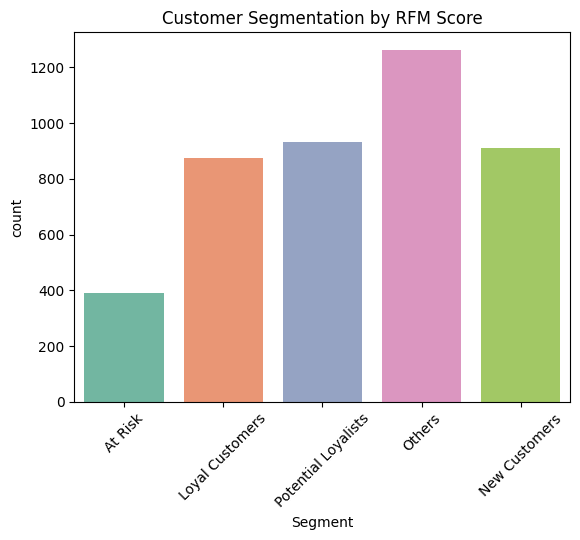

In [23]:

product_demand.to_csv('product_clusters.csv', index=False)
rfm.to_csv('rfm_segments.csv', index=False)

sns.countplot(data=rfm, x='Segment', palette='Set2')
plt.title("Customer Segmentation by RFM Score")
plt.xticks(rotation=45)
plt.show()


## Results/Observations/Outcomes from Customer Segmentation

### Key Insights:
1. **Customer Segments Identified**:
   - **Loyal Customers**: (RFM Score: 12) High recency, frequency, and monetary value. These are the most valuable customers to the business.
   - **Potential Loyalists**: (RFM Score: 8) Moderate recency and frequency with good monetary value. They have the potential to become loyal customers.
   - **At Risk**: (RFM Score: 3) Low recency, frequency, and monetary value. Requires targeted re-engagement strategies.
   - **New Customers**: (RFM Score: 4) Recent buyers with lower frequency and monetary value. Nurture them for future loyalty.
   - **Others**: (RFM Score: 10) Irregular buying patterns but contribute reasonable monetary value.

2. **Top Customer Behavior**:
   - Loyal customers account for the majority of revenue and repeat purchases.
   - Potential loyalists represent an opportunity for growth through targeted marketing.

3. **Actionable Outcomes**:
   - **Retention Strategies**: Focus on retaining loyal customers with personalized offers and rewards programs.
   - **Reactivation Campaigns**: Engage "At Risk" customers with discounts or reminders.
   - **Upselling Opportunities**: Increase frequency and monetary value of potential loyalists.

4. **Business Impact**:
   - Improved **customer engagement** and satisfaction.
   - Enhanced **revenue forecasting** through focused resource allocation.
   - Optimized **marketing strategies** for each segment.
